# Leaf classification using RNN

In [24]:
%matplotlib inline 
%matplotlib nbagg
import tensorflow as tf
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
import tensorflow as tf
from tensorflow.python.ops import rnn, rnn_cell
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import random
from sklearn import preprocessing
from utils import oneHot,batch

In [25]:
df = pd.read_csv('train.csv')
df_valid = pd.read_csv('test.csv')
labels = oneHot(df[ ['species'] ],'species')
features = list(df.columns.values)
features.remove('id')
features.remove('species')
df[:5]

,id,species,margin1,margin2,margin3,margin4,margin5,margin6,margin7,margin8,...,texture55,texture56,texture57,texture58,texture59,texture60,texture61,texture62,texture63,texture64
0,1,Acer_Opalus,0.007812,0.023438,0.023438,0.003906,0.011719,0.009766,0.027344,0,...,0.007812,0.000000,0.002930,0.002930,0.035156,0,0,0.004883,0.000000,0.025391
1,2,Pterocarya_Stenoptera,0.005859,0.000000,0.031250,0.015625,0.025391,0.001953,0.019531,0,...,0.000977,0.000000,0.000000,0.000977,0.023438,0,0,0.000977,0.039062,0.022461
2,3,Quercus_Hartwissiana,0.005859,0.009766,0.019531,0.007812,0.003906,0.005859,0.068359,0,...,0.154300,0.000000,0.005859,0.000977,0.007812,0,0,0.000000,0.020508,0.002930
3,5,Tilia_Tomentosa,0.000000,0.003906,0.023438,0.005859,0.021484,0.019531,0.023438,0,...,0.000000,0.000977,0.000000,0.000000,0.020508,0,0,0.017578,0.000000,0.047852
4,6,Quercus_Variabilis,0.005859,0.003906,0.048828,0.009766,0.013672,0.015625,0.005859,0,...,0.096680,0.000000,0.021484,0.000000,0.000000,0,0,0.000000,0.000000,0.031250


In [26]:
X_valid = df_valid[features].as_matrix()
trains = df[features].as_matrix()
labels_names = list(labels.columns.values)
labels_names = [ s.split('=')[1] for s in labels_names]
labels = labels.as_matrix()
print trains.shape
print labels.shape
print X_valid.shape

(990, 192)
(990, 99)
(594, 192)


## split X,Y

In [31]:
full_training = False

In [32]:
train_size = 0.8
if not full_training:
    idr = range(len(df))
    random.seed(44)
    random.shuffle(idr)
    X_train = trains[idr[: int(train_size * len(df)) ] , : ]
    y_train = labels[idr[: int(train_size * len(df)) ]]
else:
    X_train = trains
    y_train = labels
X_test = trains[int(train_size * len(df))  : , : ]
y_test = labels[int(train_size * len(df))  :  ]

In [33]:
tf.reset_default_graph()
# Parameters
learning_rate = 0.001
training_iters = 150000
epoches = 300
batch_size = 64
display_step = 10

# batch generator
batch_gen = batch(X_train, y_train, batch_size)

# Network Parameters
n_input = 64 # MNIST data input (img shape: 28*28)
n_steps = 3 # timesteps
n_hidden = 64 # hidden layer num of features
n_classes =  labels.shape[1]# MNIST total classes (0-9 digits)

# tf Graph input
x = tf.placeholder("float", [None, n_steps, n_input])
y = tf.placeholder("float", [None, n_classes])

# Define weights
weights = {
    'out': tf.Variable(tf.random_normal([n_hidden, n_classes]))
}
biases = {
    'out': tf.Variable(tf.random_normal([n_classes]))
}

In [34]:
def RNN(x, weights, biases):
    # Permuting batch_size and n_steps
    x = tf.transpose(x, [1, 0, 2])
    # Reshaping to (n_steps*batch_size, n_input)
    x = tf.reshape(x, [-1, n_input])
    # Split to get a list of 'n_steps' tensors of shape (batch_size, n_input)
    x = tf.split(0, n_steps, x
    # Define a lstm cell with tensorflow
    lstm_cell = tf.nn.rnn_cell.GRUCell(n_hidden)
    # Get lstm cell output
    outputs, states = rnn.rnn(lstm_cell, x, dtype=tf.float32)
    # Linear activation, using rnn inner loop last output
    return tf.matmul(outputs[-1], weights['out']) + biases['out']

pred = RNN(x, weights, biases)

pred_proba= tf.nn.softmax(pred)

# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(pred, y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# Evaluate model
correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# Initializing the variables
init = tf.initialize_all_variables()

Optimization Finished!
Testing Accuracy: 1.0


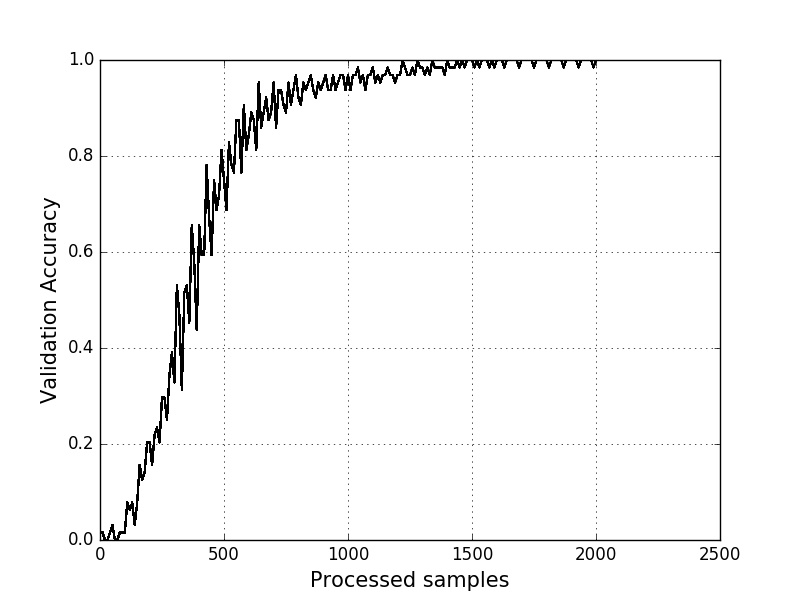

In [35]:
import IPython.display as display
XX = []
YY = []

# Launch the graph
with tf.Session() as sess:
    sess.run(init)
    step = 1
    e = 0
    # Keep training until reach max iterations
    while step * batch_size < training_iters:
        batch_x, batch_y = batch_gen.getNextBatch()
        # Reshape data to get 28 seq of 28 elements
        batch_x = batch_x.reshape((batch_size, n_steps, n_input))
        # Run optimization op (backprop)
        sess.run(optimizer, feed_dict={x: batch_x, y: batch_y})
        if step % display_step == 0:
            # Calculate batch accuracy
            acc = sess.run(accuracy, feed_dict={x: batch_x, y: batch_y})
            # Calculate batch loss
            loss = sess.run(cost, feed_dict={x: batch_x, y: batch_y})
            YY.append(acc)
            XX.append(step)
            plt.plot(XX, YY, 'black')
            plt.ylabel('Validation Accuracy', fontsize=15)
            plt.xlabel('Processed samples', fontsize=15)
            plt.title('', fontsize=20)
            plt.grid('on')
            plt.savefig("out.png")
            display.display(display.Image(filename="out.png"))
            display.clear_output(wait=True)
        step += 1
        #if (batch_gen.wasLast):
        #    e += 1
        if step == 1400:
            learning_rate = 0.1 * learning_rate
        #if step == 2000:
        #    learning_rate = 0.1 * learning_rate
    print "Optimization Finished!"
    print "Testing Accuracy:", \
        sess.run(accuracy, feed_dict={x: X_test.reshape((-1, n_steps, n_input)), y: y_test})
    
    preds = sess.run(pred_proba, feed_dict={x: X_valid.reshape((-1, n_steps, n_input)) } )
display.display(display.Image(filename="out.png"))

In [22]:
df_test = pd.read_csv('test.csv', skipinitialspace=True)
res = pd.DataFrame(preds, columns=labels_names)
res['id'] = df_test['id']
res.to_csv('subRNN1.csv', index= False)

In [23]:
res

,Alnus_Viridis,Zelkova_Serrata,Acer_Rubrum,Cornus_Macrophylla,Salix_Fragilis,Crataegus_Monogyna,Quercus_Agrifolia,Celtis_Koraiensis,Acer_Pictum,Acer_Rufinerve,...,Prunus_Avium,Quercus_Kewensis,Prunus_X_Shmittii,Fagus_Sylvatica,Quercus_Cerris,Cercis_Siliquastrum,Pterocarya_Stenoptera,Quercus_Greggii,Quercus_Variabilis,id
0,2.525712e-08,3.415072e-12,8.771308e-11,3.105674e-10,3.772505e-12,1.431456e-08,9.734963e-01,5.682673e-06,1.425071e-11,4.365832e-10,...,1.274121e-10,2.936594e-04,5.964850e-13,1.747331e-03,8.142094e-08,1.790175e-12,5.593088e-10,6.736798e-08,2.705236e-03,4
1,1.259780e-06,4.722259e-09,5.865088e-07,2.591364e-08,4.940317e-11,1.143636e-04,6.647017e-04,1.371710e-05,8.019045e-08,4.702100e-09,...,3.653824e-04,7.175439e-04,3.449514e-08,2.758810e-07,5.899758e-04,9.678488e-10,6.767515e-08,2.294279e-09,5.181649e-04,7
2,1.073217e-05,5.175997e-05,2.585336e-06,1.178323e-11,9.253057e-05,1.191383e-03,2.209163e-14,2.348540e-06,4.231428e-09,1.921451e-03,...,4.940706e-08,3.353329e-09,1.344379e-03,1.608295e-12,5.380376e-06,3.483158e-07,3.590095e-05,4.777509e-07,3.692537e-07,9
3,3.356620e-04,1.254702e-05,6.757983e-04,1.566580e-09,9.849187e-08,2.039872e-02,9.043908e-10,6.170593e-06,5.511708e-11,3.466359e-05,...,2.856981e-01,4.398415e-08,1.024426e-03,6.516683e-09,3.887867e-04,1.743183e-08,2.122059e-07,1.165530e-07,2.120566e-05,12
4,9.845855e-01,1.258280e-09,3.093451e-06,7.378327e-12,2.020187e-05,1.268058e-04,9.800672e-14,5.709867e-04,3.613842e-12,6.088385e-04,...,8.391820e-05,5.424918e-11,2.850496e-05,1.213635e-10,1.912582e-06,5.286512e-10,9.918099e-05,1.556994e-07,1.672486e-06,13
5,3.210634e-08,1.465256e-05,9.368450e-07,4.699236e-08,1.938150e-08,3.564935e-05,3.341562e-05,3.215282e-06,1.633995e-12,4.089649e-08,...,1.268720e-09,1.681191e-04,9.150693e-08,6.238127e-05,1.248183e-06,1.381716e-05,7.520628e-07,1.330833e-04,6.422801e-06,16
6,4.616281e-08,4.652951e-05,1.146138e-07,1.861624e-08,2.430275e-09,4.262479e-06,4.123430e-04,7.521786e-05,1.761639e-12,1.754590e-07,...,1.583553e-09,6.659428e-04,4.121531e-07,3.274021e-04,6.037694e-06,2.545702e-05,3.265802e-07,6.477775e-04,5.236880e-05,19
7,2.878407e-13,3.300450e-09,6.439558e-14,5.833768e-03,6.336415e-07,3.772282e-07,2.754798e-06,1.923254e-08,2.996398e-03,2.776512e-10,...,8.165433e-10,3.863594e-06,1.848672e-12,3.782609e-08,7.523197e-06,6.576656e-07,8.589986e-11,2.128740e-10,8.609850e-07,23
8,1.690431e-08,1.971157e-12,1.958615e-10,4.529453e-10,1.166336e-08,1.563972e-06,2.276785e-05,6.482923e-04,2.398909e-09,1.039806e-06,...,4.421525e-10,1.246954e-05,3.732966e-11,3.899355e-05,3.928229e-07,8.392721e-11,3.314549e-08,9.246854e-10,9.985377e-01,24
9,2.185041e-05,2.245331e-04,6.898146e-05,1.259765e-11,3.303218e-06,1.659686e-05,9.114085e-14,2.007043e-06,5.311597e-14,9.728585e-01,...,4.773318e-09,3.754520e-08,3.045823e-04,1.567652e-09,7.115867e-07,2.380611e-07,4.899232e-04,1.784383e-04,8.114768e-08,28
